<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/5%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C(cnn_lstm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📌 PPG/ECG 기반 혈압 예측 과제 정리

1. **데이터 준비**

   * PPG, ECG 신호 데이터 다운로드 후 Colab에 저장
   * 경로 수정 후 예제 코드 실행

2. **분석 및 예측**

   * GPT를 활용해 데이터 분석
   * 목표: SBP(수축기 혈압), DBP(이완기 혈압) 회귀 예측

3. **데이터 구성 (세그먼트 단위)**

   * 전체 세그먼트 개수: 약 1600개
   * 1600개 초과 세그먼트는 제외
   * 세그먼트는 반드시 **순차적으로 분할** (랜덤 셔플 금지)
   * **오버래핑 금지** → 데이터 누수 방지 목적

4. **교차 검증 (Cross Validation)**

   * **폴드 수**: 4-fold (세그먼트 1600개 기준)
   * 각 fold:

     * **훈련 + 검증**: 300개 세그먼트
     * **테스트**: 100개 세그먼트
   * 총 1600개 → 400개씩 나누어 4번 반복 평가
   * fold별 결과 → 평균 내기

5. **신호 활용 조건**

   * PPG + ECG 동시 사용 가능
   * 단, PPG 신호만으로도 잘 작동하는 경우 PPG 단독 사용 허용

6. **평가지표**

   * **MAE (Mean Absolute Error)** 사용
   * SBP, DBP 각각에 대해 MAE 계산
   * 목표: **MAE ≤ 5** (국제 표준 허용 범위)

---

👉 핵심 요약:

* PPG, ECG → SBP/DBP 회귀 예측
* 1600 세그먼트 사용, 순차 분할, 오버래핑 금지
* 4-fold cross validation (훈련 300 + 테스트 100)
* 평가 지표: SBP/DBP 각각의 MAE ≤ 5



## 데이터 분석
* 이 `.mat` 파일은 **MATLAB v7.3 형식(HDF5 기반)** 입니다.

* 최상위 키:

  * `#refs#`
  * `Subj_Wins`

* `Subj_Wins` 안에는 여러 변수들이 들어 있습니다. 주요 항목:

  * **신호 데이터**:

    * `ECG_Raw`, `PPG_Raw`, `ABP_Raw`
    * 주파수 관련: `ECG_F`, `PPG_F`, `ABP_F`
  * **혈압 관련 값**:

    * `SegSBP` (세그먼트별 수축기 혈압)
    * `SegDBP` (세그먼트별 이완기 혈압)
  * **피크/특징 정보**:

    * `ECG_RPeaks`, `PPG_SPeaks`, `ABP_SPeaks`
    * `PPG_Turns`, `ABP_Turns`
  * **메타데이터**:

    * `Age`, `Gender`, `SubjectID`, `SegmentID`, `WinID`, `WinSeqID`, `CaseID`

즉 이 파일에는 **ECG, PPG, ABP 원시 신호와 주파수/피크 정보, 그리고 세그먼트별 SBP/DBP 라벨**이 모두 포함되어 있습니다.


In [1]:

import h5py
import numpy as np
import matplotlib.pyplot as plt

# ========================
# 데이터 로딩 함수
# ========================
def load_signals_from_mat(mat_path, num_samples=5):
    """
    MATLAB .mat 파일에서 PPG, ABP, ECG 신호를 로드

    Parameters:
    - mat_path: .mat 파일 경로
    - num_samples: 로드할 샘플 개수

    Returns:
    - signals: dict {'ppg': [], 'abp': [], 'ecg': [], 'sbp': [], 'dbp': []}
    """
    signals = {'ppg': [], 'abp': [], 'ecg': [], 'sbp': [], 'dbp': []}

    with h5py.File(mat_path, 'r') as f:
        # 데이터 참조 가져오기
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        abp_refs = f['Subj_Wins']['ABP_F'][0] if 'ABP_F' in f['Subj_Wins'] else None
        ecg_refs = f['Subj_Wins']['ECG_F'][0] if 'ECG_F' in f['Subj_Wins'] else None
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]

        # 지정된 개수만큼 로드
        total = min(len(ppg_refs), num_samples)

        for i in range(total):
            # PPG 신호
            ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
            signals['ppg'].append(ppg)

            # ABP 신호 (있는 경우)
            if abp_refs is not None:
                abp = f[abp_refs[i]][()].squeeze().astype(np.float32)
                signals['abp'].append(abp)

            # ECG 신호 (있는 경우)
            if ecg_refs is not None:
                ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
                signals['ecg'].append(ecg)

            # 혈압 타겟
            sbp = float(f[sbp_refs[i]][()][0][0])
            dbp = float(f[dbp_refs[i]][()][0][0])
            signals['sbp'].append(sbp)
            signals['dbp'].append(dbp)

    return signals

In [2]:
# 셀 1: 기본 설정
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_absolute_error

# Reproducibility (best-effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 사용자 경로 지정 (실제 .mat 경로로 수정)
mat_path = "/content/drive/MyDrive/p044036.mat"

# 이전에 만든 load_signals_from_mat 함수가 있다면 호출
signals = load_signals_from_mat(mat_path, num_samples=1600)

# 안전: 최대 1600개로 맞춤
max_segs = 1600
n_segments = min(len(signals['ppg']), max_segs)
for k in ['ppg','abp','ecg','sbp','dbp']:
    signals[k] = signals[k][:n_segments]

print(f"총 세그먼트 수: {n_segments}")
# 확인 예시
print("PPG shape (segment 0) :", np.array(signals['ppg'][0]).shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
총 세그먼트 수: 1600
PPG shape (segment 0) : (1250,)


In [3]:
def preprocess_signal(signal, fs=125):
    """
    Applies bandpass filter, moving average, and normalization to a signal.
    """
    filtered_signal = bandpass_filter(signal, fs=fs)
    smoothed_signal = moving_average(filtered_signal)
    normalized_signal = normalize_signal(smoothed_signal)
    return normalized_signal

In [4]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut=0.5, highcut=8, fs=125, order=5):
    """
    Applies a Butterworth bandpass filter to the signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def moving_average(signal, window_size=5):
    """
    Applies a simple moving average filter to the signal.
    """
    if window_size % 2 == 0:
        window_size += 1  # Ensure odd window size for centering
    pad_size = window_size // 2
    padded_signal = np.pad(signal, (pad_size, pad_size), mode='edge')
    smoothed_signal = np.convolve(padded_signal, np.ones(window_size)/window_size, mode='valid')
    return smoothed_signal

def normalize_signal(signal):
    """
    Normalizes the signal to have zero mean and unit standard deviation.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        return signal - mean  # Avoid division by zero
    return (signal - mean) / std

In [5]:

fs = 125  # 샘플링 주파수

lengths = [len(s) for s in signals['ppg']]
print("PPG length unique counts:", np.unique(lengths))

# 만약 길이가 동일하다면 아래로 진행
T = lengths[0]  # 타임스텝 수 (예: 1250)
print("타임스텝 T =", T)

# X_time: (N, T, 1) — PPG 단독. ECG 병합 사용 원하면 채널 늘리기 (-> (N, T, 2))
use_ecg = True if signals['ecg'] else False
print("ECG available:", use_ecg)

X_list = []
y_list = []
for i in range(n_segments):
    p = np.array(signals['ppg'][i], dtype=float)
    p_pre = preprocess_signal(p, fs=fs)  # bandpass + moving average + normalize
    if len(p_pre) != T:
        # 안전장치: truncate or pad with zeros (shouldn't be needed if lengths equal)
        if len(p_pre) > T:
            p_pre = p_pre[:T]
        else:
            pad = np.zeros(T - len(p_pre), dtype=float)
            p_pre = np.concatenate([p_pre, pad])

    if use_ecg:
        e = np.array(signals['ecg'][i], dtype=float)
        e_pre = preprocess_signal(e, fs=fs)
        if len(e_pre) != T:
            if len(e_pre) > T:
                e_pre = e_pre[:T]
            else:
                pad = np.zeros(T - len(e_pre), dtype=float)
                e_pre = np.concatenate([e_pre, pad])
        # 2-channel input
        stacked = np.stack([p_pre, e_pre], axis=-1)  # (T, 2)
    else:
        stacked = p_pre.reshape(-1, 1)  # (T, 1)

    X_list.append(stacked)
    y_list.append([signals['sbp'][i], signals['dbp'][i]])

X_time = np.stack(X_list, axis=0).astype(np.float32)  # (N, T, C)
y = np.array(y_list, dtype=np.float32)                # (N, 2)

print("X_time shape:", X_time.shape)
print("y shape:", y.shape)


PPG length unique counts: [1250]
타임스텝 T = 1250
ECG available: True
X_time shape: (1600, 1250, 2)
y shape: (1600, 2)


In [6]:
def build_cnn_lstm(input_shape, dropout=0.2):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(2)(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [7]:
# 셀 4: 4-fold 순차 분할 (block_size = 400)
total = n_segments
assert total >= 400, "세그먼트가 최소 400개 이상이어야 합니다."
block_size = 400
n_blocks = total // block_size
assert n_blocks >= 4, f"블록 수가 4 미만: {n_blocks}"

folds = []
for b in range(4):  # exactly 4 folds: blocks 0..3
    start = b * block_size
    end = start + block_size
    trval_idx = np.arange(start, start + 300)   # train+val
    test_idx = np.arange(start + 300, end)      # test (100)
    folds.append({'trainval_idx': trval_idx, 'test_idx': test_idx})
    print(f"Fold {b}: trainval {start}-{start+299} ({len(trval_idx)}), test {start+300}-{end-1} ({len(test_idx)})")


Fold 0: trainval 0-299 (300), test 300-399 (100)
Fold 1: trainval 400-699 (300), test 700-799 (100)
Fold 2: trainval 800-1099 (300), test 1100-1199 (100)
Fold 3: trainval 1200-1499 (300), test 1500-1599 (100)


In [8]:
EPOCHS = 60
BATCH_SIZE = 32
patience = 8

mae_sbp_list = []
mae_dbp_list = []
hist_list = []

# 모델 선택: build_cnn_lstm / build_light_cnn_lstm / build_resnet1d
model_builder = build_cnn_lstm

for fi, fd in enumerate(folds):
    print("\n" + "="*40)
    print(f"Starting Fold {fi}")
    trval_idx = fd['trainval_idx']
    test_idx = fd['test_idx']

    cut = int(len(trval_idx) * 0.8)
    train_idx = trval_idx[:cut]
    val_idx = trval_idx[cut:]

    X_train, y_train = X_time[train_idx], y[train_idx]
    X_val, y_val = X_time[val_idx], y[val_idx]
    X_test, y_test = X_time[test_idx], y[test_idx]

    model = model_builder(X_time.shape[1:])

    es = callbacks.EarlyStopping(monitor='val_mae', patience=patience, restore_best_weights=True, mode='min')
    rlr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=4, min_lr=1e-6, mode='min')

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rlr],
        shuffle=False,
        verbose=1
    )
    hist_list.append(hist)

    y_pred = model.predict(X_test)
    mae_sbp = mean_absolute_error(y_test[:,0], y_pred[:,0])
    mae_dbp = mean_absolute_error(y_test[:,1], y_pred[:,1])
    print(f"Fold {fi} — Test MAE SBP: {mae_sbp:.3f}, DBP: {mae_dbp:.3f}")

    mae_sbp_list.append(mae_sbp)
    mae_dbp_list.append(mae_dbp)

print("\n" + "="*40)
print("Cross-fold MAE summary")
print(f"SBP MAE mean: {np.mean(mae_sbp_list):.3f} (std: {np.std(mae_sbp_list):.3f})")
print(f"DBP MAE mean: {np.mean(mae_dbp_list):.3f} (std: {np.std(mae_dbp_list):.3f})")


Starting Fold 0
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 423ms/step - loss: 8895.4609 - mae: 91.2359 - val_loss: 8653.7451 - val_mae: 90.2684 - learning_rate: 0.0010
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - loss: 8665.4590 - mae: 90.0657 - val_loss: 8213.2754 - val_mae: 87.9763 - learning_rate: 0.0010
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - loss: 8240.6367 - mae: 87.8325 - val_loss: 7914.6406 - val_mae: 86.3255 - learning_rate: 0.0010
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - loss: 7968.9048 - mae: 86.3200 - val_loss: 7674.5415 - val_mae: 84.9908 - learning_rate: 0.0010
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 394ms/step - loss: 7730.6167 - mae: 85.0128 - val_loss: 7462.2915 - val_mae: 83.7852 - learning_rate: 0.0010
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 550ms/step - loss: 7528.1812 - mae: 83.8657 - val_loss: 7285.7988 - val_mae: 82.7626 - learning_rate: 0.0010
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 7359.6138 - mae: 82.9079 - val_loss: 

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Fold 2 — Test MAE SBP: 79.634, DBP: 36.453

Starting Fold 3
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - loss: 8905.0635 - mae: 90.6553 - val_loss: 8409.2695 - val_mae: 88.2508 - learning_rate: 0.0010
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - loss: 8703.2695 - mae: 89.5043 - val_loss: 8026.3813 - val_mae: 85.9767 - learning_rate: 0.0010
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - loss: 8324.6572 - mae: 87.2803 - val_loss: 7763.0796 - val_mae: 84.3745 - learning_rate: 0.0010
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - loss: 8076.0391 - mae: 85.8016 - val_loss: 7543.3916 - val_mae: 83.0578 - learning_rate: 0.0010
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - loss: 7848.9692 - mae: 84.4565 - val_loss: 7346.2749 - val_mae: 81.8474 - learning_rate: 0.0010
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - loss: 7659.5811 - mae: 83.3171 - val_loss: 7174.9731 - val_mae: 80.7740 - learning_rate: 0.0010
Epoch 7/60
8/

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


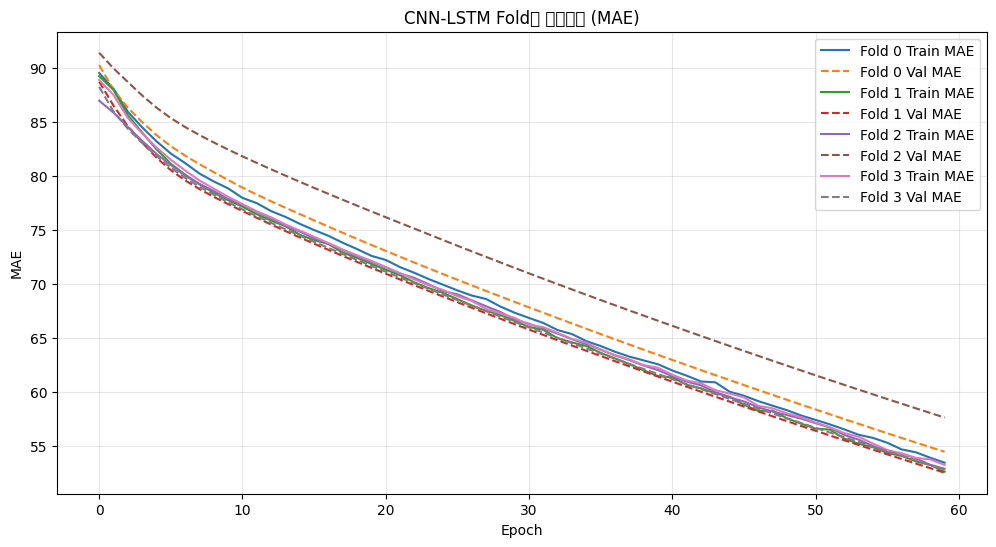

In [9]:
# 셀 6: 학습곡선(MAE) 플롯
plt.figure(figsize=(12, 6))

for fi, hist in enumerate(hist_list):
    # train MAE
    plt.plot(hist.history['mae'], label=f'Fold {fi} Train MAE', linestyle='-')
    # val MAE
    plt.plot(hist.history['val_mae'], label=f'Fold {fi} Val MAE', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('CNN-LSTM Fold별 학습곡선 (MAE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


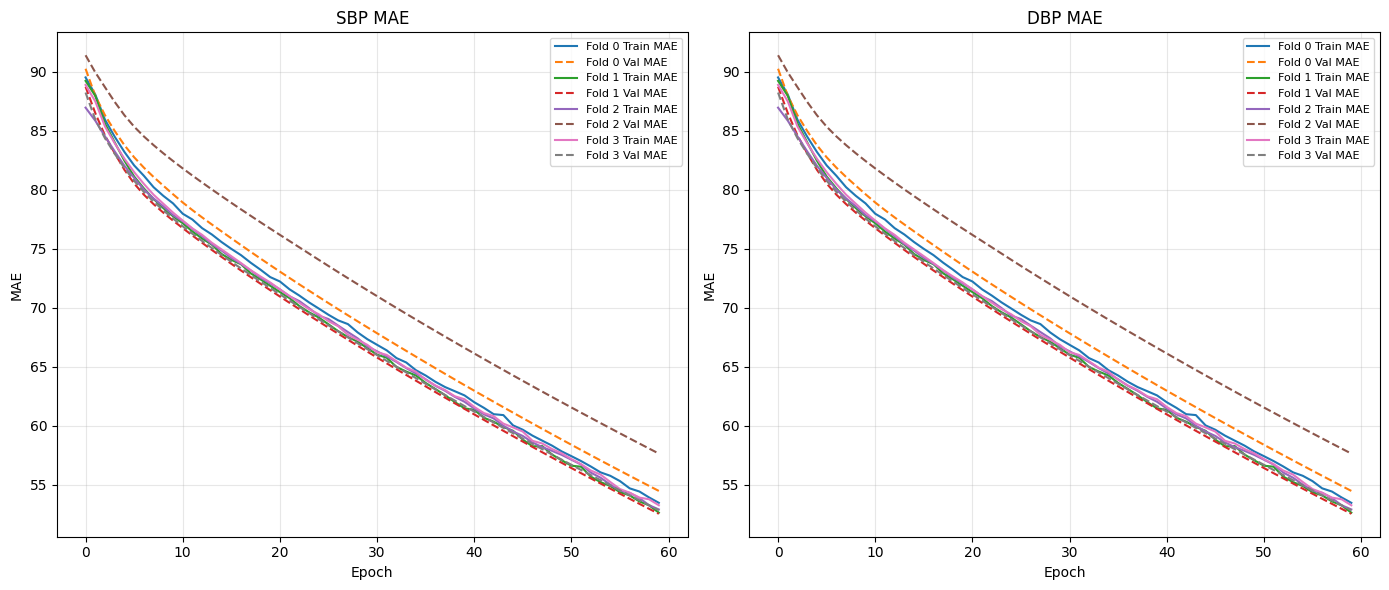

In [10]:
# 셀 7: SBP/DBP MAE 별도 플롯
plt.figure(figsize=(14, 6))

# SBP
plt.subplot(1, 2, 1)
for fi, hist in enumerate(hist_list):
    plt.plot(hist.history['mae'][:,0] if 'mae' in hist.history and isinstance(hist.history['mae'][0], (list, np.ndarray)) else hist.history['mae'],
             label=f'Fold {fi} Train MAE')
    plt.plot(hist.history['val_mae'][:,0] if 'val_mae' in hist.history and isinstance(hist.history['val_mae'][0], (list, np.ndarray)) else hist.history['val_mae'],
             label=f'Fold {fi} Val MAE', linestyle='--')
plt.title('SBP MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

# DBP
plt.subplot(1, 2, 2)
for fi, hist in enumerate(hist_list):
    plt.plot(hist.history['mae'][:,1] if 'mae' in hist.history and isinstance(hist.history['mae'][0], (list, np.ndarray)) else hist.history['mae'],
             label=f'Fold {fi} Train MAE')
    plt.plot(hist.history['val_mae'][:,1] if 'val_mae' in hist.history and isinstance(hist.history['val_mae'][0], (list, np.ndarray)) else hist.history['val_mae'],
             label=f'Fold {fi} Val MAE', linestyle='--')
plt.title('DBP MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
